In [31]:
%pip install -q langchain_community langchain_openai langchain_mongodb langchain_huggingface pymongo openai langchain
%pip install -q opencv-python moviepy faiss-cpu tiktoken torch torchvision 
%pip install --upgrade --quiet langchain--openai langchainhub openai ffmpeg ultralytics

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.16 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.3.9 which is incompatible.
langchain-community 0.2.12 requires langchain-core<0.3.0,>=0.2.30, but you have langchain-core 0.3.9 which is incompatible.
langchain-huggingface 0.0.3 requires langchain-core<0.3,>=0.1.52, but you have langchain-core 0.3.9 which is incompatible.
langchain-mongodb 0.1.8 requires langchain-core<0.3.0,>=0.2.21, but you have langchain-core 0.3.9 which is incompatible.
langchain-text-splitters 0.2.4 requires langchain-core<0.3.0,>=0.2.38, but you have langchain-core 0.3.9 which is incompatible.


In [32]:
import torch
import numpy as np
import cv2
import requests
import json
import torch.nn as nn
from openai import OpenAI
import os
import base64
import time
from moviepy.editor import VideoFileClip
from IPython.display import display, Image
from ultralytics import YOLO
from langchain.prompts import MessagesPlaceholder
from langchain.prompts import ChatPromptTemplate
from collections import Counter
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
from langchain.embeddings import HuggingFaceEmbeddings
from pymongo.errors import ConnectionFailure
from pymongo import MongoClient
import concurrent.futures
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from langchain.vectorstores import MongoDBAtlasVectorSearch
from langchain.chat_models import ChatOpenAI
from langchain.retrievers import MergerRetriever
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

In [33]:
model = "gpt-4o-mini-2024-07-18"
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
client = OpenAI(api_key=OPENAI_API_KEY)

db_client = MongoClient(MONGODB_URI)
db = db_client['dbsparta']
collection = db['dog']

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우, Malgun Gothic 폰트 경로

font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호가 깨지지 않도록 설정

## Ehco Model 베이스

#### STEP.1 Yolo Model 동영상 입력 ➡ 프레임 추출 ➡ 프레임 처리 ➡ 모델 추론 ➡ 결과 출력 (label : breed / bbox / keypoint)

In [34]:
# 비디오
source = "E:/1006/test/2.mp4"

# YOLO 모델 로드 및 실행
yolo_model = YOLO("E:/1006/model/yolo_model.pt")
conf_thresh = 0.7

# LSTM 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('E:/1006/model/lstm_model.pt', map_location=device)
print("체크포인트 키:", checkpoint.keys())

체크포인트 키: odict_keys(['keypoint_lstm.weight_ih_l0', 'keypoint_lstm.weight_hh_l0', 'keypoint_lstm.bias_ih_l0', 'keypoint_lstm.bias_hh_l0', 'keypoint_lstm.weight_ih_l1', 'keypoint_lstm.weight_hh_l1', 'keypoint_lstm.bias_ih_l1', 'keypoint_lstm.bias_hh_l1', 'skeleton_lstm.weight_ih_l0', 'skeleton_lstm.weight_hh_l0', 'skeleton_lstm.bias_ih_l0', 'skeleton_lstm.bias_hh_l0', 'skeleton_lstm.weight_ih_l1', 'skeleton_lstm.weight_hh_l1', 'skeleton_lstm.bias_ih_l1', 'skeleton_lstm.bias_hh_l1', 'fc.weight', 'fc.bias'])


In [35]:
# 품종 매핑 딕셔너리 생성
breed_mapping = {
    "Chihuahua": "치와와",
    "Japanese_spaniel": "재패니즈 스패니얼",
    "Maltese_dog": "말티즈",
    "Pekinese": "페키니즈",
    "Shih-Tzu": "시추",
    "Blenheim_spaniel": "블레넘 스패니얼",
    "Papillon": "파피용",
    "Toy_terrier": "토이 테리어",
    "Rhodesian_ridgeback": "로디지안 리지백",
    "Afghan_hound": "아프간 하운드",
    "Basset": "바셋",
    "Beagle": "비글",
    "Bloodhound": "블러드하운드",
    "Bluetick": "블루틱 쿤하운드",
    "Black-and-tan_coonhound": "블랙앤탄 쿤하운드",
    "Walker_hound": "워커 하운드",
    "English_foxhound": "잉글리시 폭스하운드",
    "Redbone": "레드본 하운드",
    "Borzoi": "보르조이",
    "Irish_wolfhound": "아이리시 울프하운드",
    "Italian_greyhound": "이탈리안 그레이하운드",
    "Whippet": "휘핏",
    "Ibizan_hound": "이비전 하운드",
    "Norwegian_elkhound": "노르웨이 엘크하운드",
    "Otterhound": "오터하운드",
    "Saluki": "살루키",
    "Scottish_deerhound": "스코티시 디어하운드",
    "Weimaraner": "바이마라너",
    "Staffordshire_bullterrier": "스태퍼드셔 불테리어",
    "American_Staffordshire_terrier": "아메리칸 스태퍼드셔 테리어",
    "Bedlington_terrier": "베들링턴 테리어",
    "Border_terrier": "보더 테리어",
    "Kerry_blue_terrier": "케리 블루 테리어",
    "Irish_terrier": "아이리시 테리어",
    "Norfolk_terrier": "노퍽 테리어",
    "Norwich_terrier": "노리치 테리어",
    "Yorkshire_terrier": "요크셔 테리어",
    "Wire-haired_fox_terrier": "와이어 폭스 테리어",
    "Lakeland_terrier": "레이클랜드 테리어",
    "Sealyham_terrier": "실리엄 테리어",
    "Airedale": "에어데일",
    "Cairn": "케언 테리어",
    "Australian_terrier": "오스트레일리안 테리어",
    "Dandie_Dinmont": "댄디 딘몬트 테리어",
    "Boston_bull": "보스턴 불",
    "Miniature_schnauzer": "미니어처 슈나우저",
    "Giant_schnauzer": "자이언트 슈나우저",
    "Standard_schnauzer": "스탠다드 슈나우저",
    "Scotch_terrier": "스카치 테리어",
    "Tibetan_terrier": "티베탄 테리어",
    "Silky_terrier": "실키 테리어",
    "Soft-coated_wheaten_terrier": "소프트 코티드 휘튼 테리어",
    "West_Highland_white_terrier": "웨스트 하이랜드 화이트 테리어",
    "Lhasa": "라사압소",
    "Flat-coated_retriever": "플랫 코티드 리트리버",
    "Curly-coated_retriever": "컬리 코티드 리트리버",
    "Golden_retriever": "골든 리트리버",
    "Labrador_retriever": "래브라도 리트리버",
    "Chesapeake_Bay_retriever": "체서피크 베이 리트리버",
    "German_short-haired_pointer": "저먼 쇼트헤어드 포인터",
    "Vizsla": "비즐라",
    "English_setter": "잉글리시 세터",
    "Irish_setter": "아이리시 세터",
    "Gordon_setter": "고든 세터",
    "Brittany_spaniel": "브리타니 스패니얼",
    "Clumber": "클럼버 스패니얼",
    "English_springer": "잉글리시 스프링거 스패니얼",
    "Welsh_springer_spaniel": "웰시 스프링거 스패니얼",
    "Cocker_spaniel": "코커 스패니얼",
    "Sussex_spaniel": "서식스 스패니얼",
    "Irish_water_spaniel": "아이리시 워터 스패니얼",
    "Kuvasz": "쿠바즈",
    "Schipperke": "스키퍼키",
    "Groenendael": "그로넨달",
    "Malinois": "말리노이즈",
    "Briard": "브리아드",
    "Kelpie": "켈피",
    "Komondor": "코몬도르",
    "Old_English_sheepdog": "올드 잉글리시 쉽독",
    "Shetland_sheepdog": "셰틀랜드 쉽독",
    "Collie": "콜리",
    "Border_collie": "보더 콜리",
    "Bouvier_des_Flandres": "부비에 데 플랑드르",
    "Rottweiler": "로트와일러",
    "German_shepherd": "저먼 셰퍼드",
    "Doberman": "도베르만",
    "Miniature_pinscher": "미니어처 핀셔",
    "Greater_Swiss_Mountain_dog": "그레이터 스위스 마운틴 독",
    "Bernese_mountain_dog": "버니즈 마운틴 독",
    "Appenzeller": "아펜젤러",
    "EntleBucher": "엔틀레부처",
    "Boxer": "복서",
    "Bull_mastiff": "불마스티프",
    "Tibetan_mastiff": "티베탄 마스티프",
    "French_bulldog": "프렌치 불도그",
    "Great_Dane": "그레이트 데인",
    "Saint_Bernard": "세인트 버나드",
    "Eskimo_dog": "에스키모 독",
    "Malamute": "말라뮤트",
    "Siberian_husky": "시베리안 허스키",
    "Affenpinscher": "아펜핀셔",
    "Basenji": "바센지",
    "Pug": "퍼그",
    "Leonberg": "레온베르거",
    "Newfoundland": "뉴펀들랜드",
    "Great_Pyrenees": "그레이트 피레니즈",
    "Samoyed": "사모예드",
    "Pomeranian": "포메라니안",
    "Chow": "차우차우",
    "Keeshond": "키스혼트",
    "Brabancon_griffon": "브라반손 그리펀",
    "Pembroke": "펨브로크 웰시 코기",
    "Cardigan": "카디건 웰시 코기",
    "Toy_poodle": "토이 푸들",
    "Miniature_poodle": "미니어처 푸들",
    "Standard_poodle": "스탠다드 푸들",
    "Mexican_hairless": "멕시칸 헤어리스",
    "Dingo": "딩고",
    "Dhole": "도울",
    "African_hunting_dog": "아프리칸 헌팅 독"
}


video 1/1 (frame 1/135) E:\1006\test\2.mp4: 640x384 (no detections), 379.6ms
video 1/1 (frame 2/135) E:\1006\test\2.mp4: 640x384 (no detections), 236.7ms
video 1/1 (frame 3/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 210.7ms
video 1/1 (frame 4/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 192.8ms
video 1/1 (frame 5/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 197.5ms
video 1/1 (frame 6/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 196.5ms
video 1/1 (frame 7/135) E:\1006\test\2.mp4: 640x384 (no detections), 201.7ms
video 1/1 (frame 8/135) E:\1006\test\2.mp4: 640x384 1 Tzu, 195.1ms
video 1/1 (frame 9/135) E:\1006\test\2.mp4: 640x384 (no detections), 203.2ms
video 1/1 (frame 10/135) E:\1006\test\2.mp4: 640x384 (no detections), 222.1ms
video 1/1 (frame 11/135) E:\1006\test\2.mp4: 640x384 (no detections), 196.9ms
video 1/1 (frame 12/135) E:\1006\test\2.mp4: 640x384 (no detections), 192.6ms
video 1/1 (frame 13/135) E:\1006\test\2.mp4: 640x384 (no detections), 192.1ms
video 1/1 (f

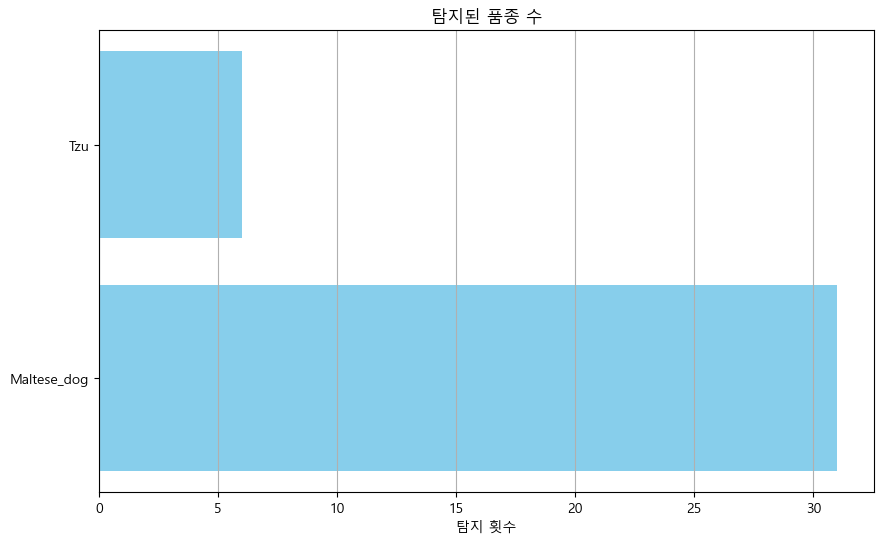

YOLO 분석 결과:
가장 많이 탐지된 품종: 말티즈 (전체 탐지 중 83.78%)
yolo_text:말티즈


In [36]:
# YOLO 키포인트를 LSTM 형식으로 변환
def convert_yolo_to_lstm(yolo_keypoints):
    image_width, image_height = 640, 384
    yolo_to_lstm_mapping = {
        16: 0, 23: 4, 8: 5, 2: 6, 7: 7, 1: 8, 10: 9, 4: 10, 9: 11, 3: 12, 12: 13, 13: 14
    }
    lstm_keypoints = np.zeros((15, 2), dtype=float)
    
    for yolo_index, lstm_index in yolo_to_lstm_mapping.items():
        if yolo_index < yolo_keypoints.shape[0]:
            x, y = yolo_keypoints[yolo_index]
            lstm_keypoints[lstm_index] = [x / image_width, y / image_height]
    
    # 이마, 입꼬리, 아래 입술 중앙 처리 (가능한 경우에만)
    if 20 < yolo_keypoints.shape[0]:
        lstm_keypoints[1] = yolo_keypoints[20] / np.array([image_width, image_height])
    if 17 < yolo_keypoints.shape[0]:
        lstm_keypoints[2] = lstm_keypoints[3] = yolo_keypoints[17] / np.array([image_width, image_height])
    
    return lstm_keypoints

# 스켈레톤 데이터 생성
def create_skeleton(keypoints):
    DOG_SKELETON = [
        [0, 1], [0, 2], [2, 3], [1, 4], [4, 5], [4, 6], [5, 7], [6, 8],
        [9, 11], [10, 12], [4, 13], [13, 14], [9, 13], [10, 13], [5, 9],
        [6, 10], [5, 6], [9, 10]
    ]
    skeleton = []
    for start, end in DOG_SKELETON:
        start_point, end_point = keypoints[start], keypoints[end]
        skeleton.extend([start_point[0], start_point[1], end_point[0], end_point[1]])
    return skeleton

# YOLO 결과 처리 및 LSTM 입력 준비
lstm_keypoint_sequence = []
skeleton_sequence = []
breed_counter = Counter()

results = yolo_model.predict(source=source, save=True, conf=conf_thresh, stream=True)
for r in results:
    if r.keypoints is not None and len(r.keypoints) > 0:
        yolo_keypoints = r.keypoints[0].cpu().numpy()
        lstm_keypoints = convert_yolo_to_lstm(yolo_keypoints)
        lstm_keypoint_sequence.append(lstm_keypoints)
        skeleton = create_skeleton(lstm_keypoints)
        skeleton_sequence.append(skeleton)
        
        # YOLO 결과에서 품종 정보 추출 및 카운트
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            class_name = r.names[cls]
            breed_counter[class_name] += 1  # 품종 등장 횟수 증가

lstm_keypoint_sequence = np.array(lstm_keypoint_sequence)
skeleton_sequence = np.array(skeleton_sequence)

print(f"LSTM 키포인트 시퀀스 형태: {lstm_keypoint_sequence.shape}")
print(f"스켈레톤 시퀀스 형태: {skeleton_sequence.shape}")

# 가장 많이 탐지된 품종 선택
if breed_counter:
    most_common_breed = breed_counter.most_common(1)[0][0]
    total_detections = sum(breed_counter.values())
    breed_percentage = (breed_counter[most_common_breed] / total_detections) * 100

    # 영어 품종 이름을 한국어로 변환
    most_common_breed_ko = breed_mapping.get(most_common_breed, most_common_breed)  # 변경 X
    
    # YOLO 결과에 한국어 품종 이름 사용
    yolo_result = f"가장 많이 탐지된 품종: {most_common_breed_ko} (전체 탐지 중 {breed_percentage:.2f}%)"
    yolo_text = most_common_breed_ko  # yolo_text도 한국어로 설정
else:
    yolo_result = "믹스"
    yolo_text = "믹스"

# 시각적으로 결과 확인
def plot_results(breed_counter):
    breeds = list(breed_counter.keys())
    counts = list(breed_counter.values())

    plt.figure(figsize=(10, 6))
    plt.barh(breeds, counts, color='skyblue')
    plt.xlabel('탐지 횟수')
    plt.title('탐지된 품종 수')
    plt.grid(axis='x')
    plt.show()
    
# 결과 시각화
plot_results(breed_counter)

print("YOLO 분석 결과:")
print(yolo_result)
print(f"yolo_text:{yolo_text}")

#### STEP.2 Yolo Output Data 변환 (yolo v8m, size:640x384)


video 1/1 (frame 1/135) E:\1006\test\2.mp4: 640x384 (no detections), 205.4ms
video 1/1 (frame 2/135) E:\1006\test\2.mp4: 640x384 (no detections), 207.0ms
video 1/1 (frame 3/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 201.5ms
video 1/1 (frame 4/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 195.2ms
video 1/1 (frame 5/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 201.2ms
video 1/1 (frame 6/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 203.7ms
video 1/1 (frame 7/135) E:\1006\test\2.mp4: 640x384 (no detections), 203.0ms
video 1/1 (frame 8/135) E:\1006\test\2.mp4: 640x384 1 Tzu, 194.8ms
video 1/1 (frame 9/135) E:\1006\test\2.mp4: 640x384 (no detections), 195.1ms
video 1/1 (frame 10/135) E:\1006\test\2.mp4: 640x384 (no detections), 202.7ms
video 1/1 (frame 11/135) E:\1006\test\2.mp4: 640x384 (no detections), 202.3ms
video 1/1 (frame 12/135) E:\1006\test\2.mp4: 640x384 (no detections), 202.6ms
video 1/1 (frame 13/135) E:\1006\test\2.mp4: 640x384 (no detections), 203.2ms
video 1/1 (f

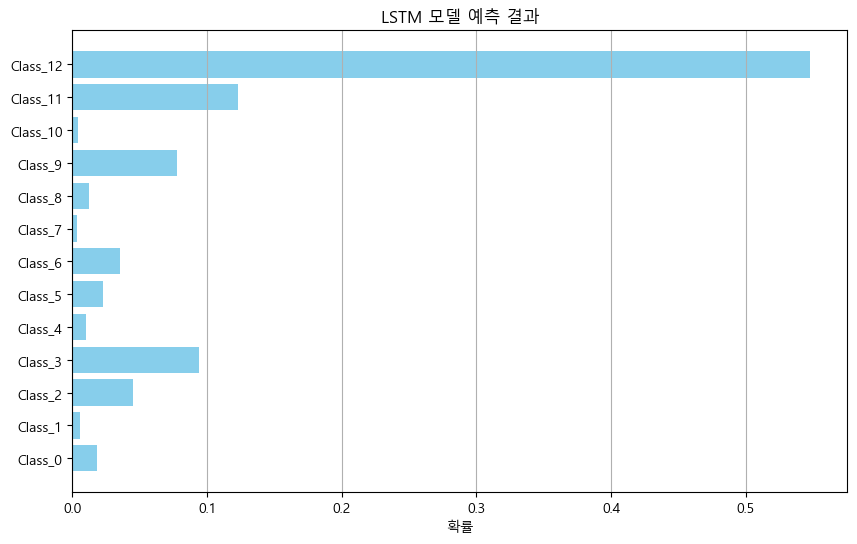

In [37]:
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO

# YOLO 키포인트를 LSTM 형식으로 변환
def convert_yolo_to_lstm(yolo_keypoints):
    image_width, image_height = 640, 384
    yolo_to_lstm_mapping = {
        16: 0, 23: 4, 8: 5, 2: 6, 7: 7, 1: 8, 10: 9, 4: 10, 9: 11, 3: 12, 12: 13, 13: 14
    }
    lstm_keypoints = np.zeros((15, 2), dtype=float)
    
    for yolo_index, lstm_index in yolo_to_lstm_mapping.items():
        if yolo_index < yolo_keypoints.shape[0]:
            x, y = yolo_keypoints[yolo_index]
            if x == 0 and y == 0:  # YOLO에서 감지되지 않으면 0,0 처리
                lstm_keypoints[lstm_index] = [0, 0]
            else:
                lstm_keypoints[lstm_index] = [x / image_width, y / image_height]

    # 이마, 입꼬리, 아래 입술 중앙 처리 (가능한 경우에만)
    if yolo_keypoints.shape[0] > 20:
        lstm_keypoints[1] = yolo_keypoints[20] / np.array([image_width, image_height])
    if yolo_keypoints.shape[0] > 17:
        lstm_keypoints[2] = lstm_keypoints[3] = yolo_keypoints[17] / np.array([image_width, image_height])

    return lstm_keypoints

# 스켈레톤 데이터 생성
def create_skeleton(keypoints):
    DOG_SKELETON = [
        [0, 1], [0, 2], [2, 3], [1, 4], [4, 5], [4, 6], [5, 7], [6, 8],
        [9, 11], [10, 12], [4, 13], [13, 14], [9, 13], [10, 13], [5, 9],
        [6, 10], [5, 6], [9, 10]
    ]
    skeleton = []
    for start, end in DOG_SKELETON:
        start_point, end_point = keypoints[start], keypoints[end]
        skeleton.extend([start_point[0], start_point[1], end_point[0], end_point[1]])
    return skeleton

# YOLO 결과 처리 및 LSTM 입력 준비
lstm_keypoint_sequence = []
skeleton_sequence = []

results = yolo_model.predict(source=source, save=True, conf=conf_thresh, stream=True)
for r in results:
    if r.keypoints is not None and len(r.keypoints) > 0:
        yolo_keypoints = r.keypoints[0].cpu().numpy()
        lstm_keypoints = convert_yolo_to_lstm(yolo_keypoints)
        lstm_keypoint_sequence.append(lstm_keypoints)
        skeleton = create_skeleton(lstm_keypoints)
        skeleton_sequence.append(skeleton)

lstm_keypoint_sequence = np.array(lstm_keypoint_sequence)
skeleton_sequence = np.array(skeleton_sequence)

print(f"LSTM 키포인트 시퀀스 형태: {lstm_keypoint_sequence.shape}")
print(f"스켈레톤 시퀀스 형태: {skeleton_sequence.shape}")

# LSTM 모델 정의
class ImprovedLSTMModel(nn.Module):
    def __init__(self, keypoint_size, skeleton_size, hidden_size, num_layers, num_classes):
        super(ImprovedLSTMModel, self).__init__()
        self.keypoint_lstm = nn.LSTM(keypoint_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.skeleton_lstm = nn.LSTM(skeleton_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, keypoints, skeleton):
        _, (h_n_keypoints, _) = self.keypoint_lstm(keypoints)
        _, (h_n_skeleton, _) = self.skeleton_lstm(skeleton)
        combined = torch.cat((h_n_keypoints[-1], h_n_skeleton[-1]), dim=1)
        out = self.dropout(combined)
        out = self.fc(out)
        return out
# 모델 파라미터 및 메타데이터 설정
keypoint_size = checkpoint.get('keypoint_size', 30)
skeleton_size = checkpoint.get('skeleton_size', 72)
hidden_size = checkpoint.get('hidden_size', 128)
num_layers = checkpoint.get('num_layers', 2)
num_classes = checkpoint.get('num_classes', checkpoint['fc.weight'].size(0))
all_class_names = checkpoint.get('classes', [f'Class_{i}' for i in range(num_classes)])
metadata = checkpoint.get('metadata', {})

# all_meta 정의 (예시)
all_meta = [
    {"pain": "이상없음", "disease": "이상없음", "emotion": "기쁨", "abnormal_action": "이상없음"} for _ in range(num_classes)
]

print(f"키포인트 크기: {keypoint_size}")
print(f"스켈레톤 크기: {skeleton_size}")
print(f"은닉층 크기: {hidden_size}")
print(f"레이어 수: {num_layers}")
print(f"클래스 수: {num_classes}")
print(f"클래스 이름: {all_class_names}")

# 모델 인스턴스 생성
model = ImprovedLSTMModel(keypoint_size, skeleton_size, hidden_size, num_layers, num_classes).to(device)

# 가중치 직접 로드
try:
    model.load_state_dict(checkpoint['model_state_dict'])
except KeyError:
    print("'model_state_dict' 키를 찾을 수 없습니다. 체크포인트에서 직접 가중치를 로드합니다.")
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

model.eval()

# 시퀀스 길이 표준화 (패딩 적용)
target_length = 100
if len(lstm_keypoint_sequence) > target_length:
    lstm_keypoint_sequence = lstm_keypoint_sequence[:target_length]
    skeleton_sequence = skeleton_sequence[:target_length]
elif len(lstm_keypoint_sequence) < target_length:
    padding = [np.zeros_like(lstm_keypoint_sequence[-1])] * (target_length - len(lstm_keypoint_sequence))
    lstm_keypoint_sequence = np.concatenate([lstm_keypoint_sequence, padding], axis=0)
    skeleton_padding = [np.zeros_like(skeleton_sequence[-1])] * (target_length - len(skeleton_sequence))
    skeleton_sequence = np.concatenate([skeleton_sequence, skeleton_padding], axis=0)

# 텐서로 변환 및 차원 조정
keypoints_tensor = torch.FloatTensor(lstm_keypoint_sequence).to(device).unsqueeze(0)
skeleton_tensor = torch.FloatTensor(skeleton_sequence).to(device).unsqueeze(0)

print(f"키포인트 텐서 형태: {keypoints_tensor.shape}")
print(f"스켈레톤 텐서 형태: {skeleton_tensor.shape}")

# 키포인트 텐서 형태 조정
if keypoints_tensor.shape[-2] == 15 and keypoints_tensor.shape[-1] == 2:
    keypoints_tensor = keypoints_tensor.view(keypoints_tensor.shape[0], keypoints_tensor.shape[1], -1)

print(f"조정된 키포인트 텐서 형태: {keypoints_tensor.shape}")
print(f"조정된 스켈레톤 텐서 형태: {skeleton_tensor.shape}")

# LSTM 입력 형태 확인
assert keypoints_tensor.dim() == 3, f"키포인트 텐서는 3차원이어야 합니다. 현재: {keypoints_tensor.dim()}D"
assert skeleton_tensor.dim() == 3, f"스켈레톤 텐서는 3차원이어야 합니다. 현재: {skeleton_tensor.dim()}D"
assert keypoints_tensor.shape[-1] == 30, f"키포인트 텐서의 마지막 차원은 30이어야 합니다. 현재: {keypoints_tensor.shape[-1]}"
assert skeleton_tensor.shape[-1] == 72, f"스켈레톤 텐서의 마지막 차원은 72여야 합니다. 현재: {skeleton_tensor.shape[-1]}"

# 예측
with torch.no_grad():
    output = model(keypoints_tensor, skeleton_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

# 예측 결과와 연관된 메타데이터 가져오기
predicted_action = all_class_names[predicted_class]
associated_metadata = all_meta[predicted_class] if predicted_class < len(all_meta) else {}

# 예측 결과 출력
print(f"예측된 클래스: {predicted_action}")
print(f"클래스별 확률:")
for i, prob in enumerate(probabilities[0]):
    print(f"  {all_class_names[i]}: {prob.item():.4f}")

# 메타데이터 출력
print("\n예측된 클래스의 메타데이터:")
if metadata and predicted_class < len(metadata):
    class_metadata = metadata[predicted_class]
    print(f"  통증: {class_metadata.get('pain', 'N/A')}")
    print(f"  질병: {class_metadata.get('disease', 'N/A')}")
    print(f"  감정: {class_metadata.get('emotion', 'N/A')}")
    print(f"  비정상 행동: {class_metadata.get('abnormal_action', 'N/A')}")
else:
    print("  이 클래스에 대한 메타데이터가 없습니다.")

# LSTM 모델 예측 결과 시각화
def plot_lstm_results(probabilities, all_class_names):
    plt.figure(figsize=(10, 6))
    plt.barh(all_class_names, probabilities[0].cpu().numpy(), color='skyblue')
    plt.xlabel('확률')
    plt.title('LSTM 모델 예측 결과')
    plt.grid(axis='x')
    plt.show()

# LSTM 예측 결과 시각화
plot_lstm_results(probabilities, all_class_names)


video 1/1 (frame 1/135) E:\1006\test\2.mp4: 640x384 (no detections), 214.6ms
video 1/1 (frame 2/135) E:\1006\test\2.mp4: 640x384 (no detections), 224.1ms
video 1/1 (frame 3/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 216.4ms
video 1/1 (frame 4/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 210.7ms
video 1/1 (frame 5/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 210.0ms
video 1/1 (frame 6/135) E:\1006\test\2.mp4: 640x384 1 Maltese_dog, 202.8ms
video 1/1 (frame 7/135) E:\1006\test\2.mp4: 640x384 (no detections), 214.5ms
video 1/1 (frame 8/135) E:\1006\test\2.mp4: 640x384 1 Tzu, 203.7ms
video 1/1 (frame 9/135) E:\1006\test\2.mp4: 640x384 (no detections), 213.1ms
video 1/1 (frame 10/135) E:\1006\test\2.mp4: 640x384 (no detections), 214.8ms
video 1/1 (frame 11/135) E:\1006\test\2.mp4: 640x384 (no detections), 203.5ms
video 1/1 (frame 12/135) E:\1006\test\2.mp4: 640x384 (no detections), 214.2ms
video 1/1 (frame 13/135) E:\1006\test\2.mp4: 640x384 (no detections), 204.3ms
video 1/1 (f

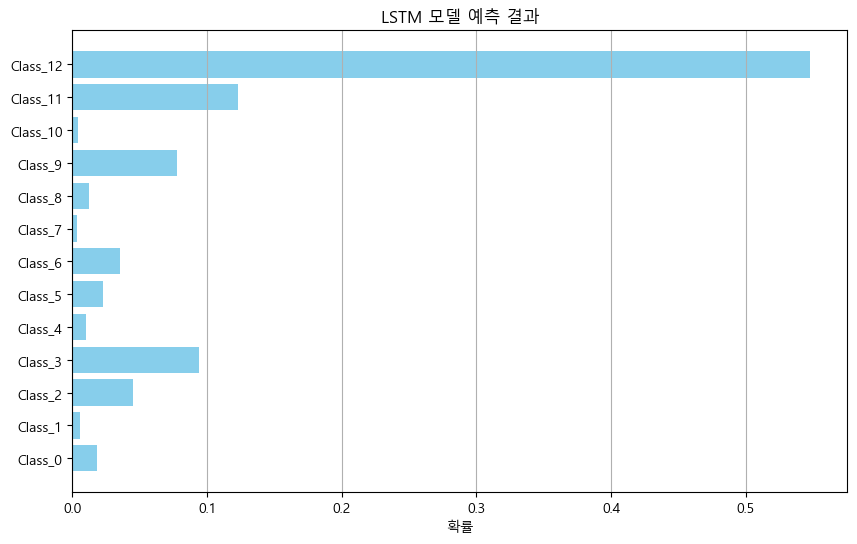

In [38]:
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우, Malgun Gothic 폰트 경로
font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rc('font', family=font_prop.get_name())
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호가 깨지지 않도록 설정

# YOLO 키포인트를 LSTM 형식으로 변환
def convert_yolo_to_lstm(yolo_keypoints):
    image_width, image_height = 640, 384
    yolo_to_lstm_mapping = {
        16: 0, 23: 4, 8: 5, 2: 6, 7: 7, 1: 8, 10: 9, 4: 10, 9: 11, 3: 12, 12: 13, 13: 14
    }
    lstm_keypoints = np.zeros((15, 2), dtype=float)
    
    for yolo_index, lstm_index in yolo_to_lstm_mapping.items():
        if yolo_index < yolo_keypoints.shape[0]:
            x, y = yolo_keypoints[yolo_index]
            lstm_keypoints[lstm_index] = [x / image_width, y / image_height]
    
    # 이마, 입꼬리, 아래 입술 중앙 처리 (가능한 경우에만)
    if 20 < yolo_keypoints.shape[0]:
        lstm_keypoints[1] = yolo_keypoints[20] / np.array([image_width, image_height])
    if 17 < yolo_keypoints.shape[0]:
        lstm_keypoints[2] = lstm_keypoints[3] = yolo_keypoints[17] / np.array([image_width, image_height])
    
    return lstm_keypoints

# 스켈레톤 데이터 생성
def create_skeleton(keypoints):
    DOG_SKELETON = [
        [0, 1], [0, 2], [2, 3], [1, 4], [4, 5], [4, 6], [5, 7], [6, 8],
        [9, 11], [10, 12], [4, 13], [13, 14], [9, 13], [10, 13], [5, 9],
        [6, 10], [5, 6], [9, 10]
    ]
    skeleton = []
    for start, end in DOG_SKELETON:
        start_point, end_point = keypoints[start], keypoints[end]
        skeleton.extend([start_point[0], start_point[1], end_point[0], end_point[1]])
    return skeleton

# YOLO 결과 처리 및 LSTM 입력 준비
lstm_keypoint_sequence = []
skeleton_sequence = []
breed_counter = Counter()

results = yolo_model.predict(source=source, save=True, conf=conf_thresh, stream=True)
for r in results:
    if r.keypoints is not None and len(r.keypoints) > 0:
        yolo_keypoints = r.keypoints[0].cpu().numpy()
        lstm_keypoints = convert_yolo_to_lstm(yolo_keypoints)
        lstm_keypoint_sequence.append(lstm_keypoints)
        skeleton = create_skeleton(lstm_keypoints)
        skeleton_sequence.append(skeleton)
        
        # YOLO 결과에서 품종 정보 추출 및 카운트
        boxes = r.boxes
        for box in boxes:
            cls = int(box.cls[0])
            class_name = r.names[cls]
            breed_counter[class_name] += 1  # 품종 등장 횟수 증가

lstm_keypoint_sequence = np.array(lstm_keypoint_sequence)
skeleton_sequence = np.array(skeleton_sequence)

print(f"LSTM 키포인트 시퀀스 형태: {lstm_keypoint_sequence.shape}")
print(f"스켈레톤 시퀀스 형태: {skeleton_sequence.shape}")

# LSTM 모델 정의
class ImprovedLSTMModel(nn.Module):
    def __init__(self, keypoint_size, skeleton_size, hidden_size, num_layers, num_classes):
        super(ImprovedLSTMModel, self).__init__()
        self.keypoint_lstm = nn.LSTM(keypoint_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.skeleton_lstm = nn.LSTM(skeleton_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, keypoints, skeleton):
        _, (h_n_keypoints, _) = self.keypoint_lstm(keypoints)
        _, (h_n_skeleton, _) = self.skeleton_lstm(skeleton)
        combined = torch.cat((h_n_keypoints[-1], h_n_skeleton[-1]), dim=1)
        out = self.dropout(combined)
        out = self.fc(out)
        return out

# 모델 파라미터 및 메타데이터 설정
keypoint_size = checkpoint.get('keypoint_size', 30)
skeleton_size = checkpoint.get('skeleton_size', 72)
hidden_size = checkpoint.get('hidden_size', 128)
num_layers = checkpoint.get('num_layers', 2)
num_classes = checkpoint.get('num_classes', checkpoint['fc.weight'].size(0))
all_class_names = checkpoint.get('classes', [f'Class_{i}' for i in range(num_classes)])
metadata = checkpoint.get('metadata', {})

# all_meta 정의 (예시)
all_meta = [
    {"pain": "이상없음", "disease": "이상없음", "emotion": "기쁨", "abnormal_action": "이상없음"} for _ in range(num_classes)
]

print(f"키포인트 크기: {keypoint_size}")
print(f"스켈레톤 크기: {skeleton_size}")
print(f"은닉층 크기: {hidden_size}")
print(f"레이어 수: {num_layers}")
print(f"클래스 수: {num_classes}")
print(f"클래스 이름: {all_class_names}")

# 모델 인스턴스 생성
model = ImprovedLSTMModel(keypoint_size, skeleton_size, hidden_size, num_layers, num_classes).to(device)

# 가중치 직접 로드
try:
    model.load_state_dict(checkpoint['model_state_dict'])
except KeyError:
    print("'model_state_dict' 키를 찾을 수 없습니다. 체크포인트에서 직접 가중치를 로드합니다.")
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

model.eval()

# 시퀀스 길이 표준화 (패딩 적용)
target_length = 100
if len(lstm_keypoint_sequence) > target_length:
    lstm_keypoint_sequence = lstm_keypoint_sequence[:target_length]
    skeleton_sequence = skeleton_sequence[:target_length]
elif len(lstm_keypoint_sequence) < target_length:
    padding = [np.zeros_like(lstm_keypoint_sequence[-1])] * (target_length - len(lstm_keypoint_sequence))
    lstm_keypoint_sequence = np.concatenate([lstm_keypoint_sequence, padding], axis=0)
    skeleton_padding = [np.zeros_like(skeleton_sequence[-1])] * (target_length - len(skeleton_sequence))
    skeleton_sequence = np.concatenate([skeleton_sequence, skeleton_padding], axis=0)

# 텐서로 변환 및 차원 조정
keypoints_tensor = torch.FloatTensor(lstm_keypoint_sequence).to(device).unsqueeze(0)
skeleton_tensor = torch.FloatTensor(skeleton_sequence).to(device).unsqueeze(0)

print(f"키포인트 텐서 형태: {keypoints_tensor.shape}")
print(f"스켈레톤 텐서 형태: {skeleton_tensor.shape}")

# 키포인트 텐서 형태 조정
if keypoints_tensor.shape[-2] == 15 and keypoints_tensor.shape[-1] == 2:
    keypoints_tensor = keypoints_tensor.view(keypoints_tensor.shape[0], keypoints_tensor.shape[1], -1)

print(f"조정된 키포인트 텐서 형태: {keypoints_tensor.shape}")
print(f"조정된 스켈레톤 텐서 형태: {skeleton_tensor.shape}")

# LSTM 입력 형태 확인
assert keypoints_tensor.dim() == 3, f"키포인트 텐서는 3차원이어야 합니다. 현재: {keypoints_tensor.dim()}D"
assert skeleton_tensor.dim() == 3, f"스켈레톤 텐서는 3차원이어야 합니다. 현재: {skeleton_tensor.dim()}D"
assert keypoints_tensor.shape[-1] == 30, f"키포인트 텐서의 마지막 차원은 30이어야 합니다. 현재: {keypoints_tensor.shape[-1]}"
assert skeleton_tensor.shape[-1] == 72, f"스켈레톤 텐서의 마지막 차원은 72여야 합니다. 현재: {skeleton_tensor.shape[-1]}"

# 예측
with torch.no_grad():
    output = model(keypoints_tensor, skeleton_tensor)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

# 예측 결과와 연관된 메타데이터 가져오기
predicted_action = all_class_names[predicted_class]
associated_metadata = all_meta[predicted_class] if predicted_class < len(all_meta) else {}

# 예측 결과 출력
print(f"예측된 클래스: {predicted_action}")
print(f"클래스별 확률:")
for i, prob in enumerate(probabilities[0]):
    print(f"  {all_class_names[i]}: {prob.item():.4f}")

# 메타데이터 출력
print("\n예측된 클래스의 메타데이터:")
if associated_metadata:
    print(f"  통증: {associated_metadata.get('pain', 'N/A')}")
    print(f"  질병: {associated_metadata.get('disease', 'N/A')}")
    print(f"  감정: {associated_metadata.get('emotion', 'N/A')}")
    print(f"  비정상 행동: {associated_metadata.get('abnormal_action', 'N/A')}")
else:
    print("  이 클래스에 대한 메타데이터가 없습니다.")
# LSTM 모델 예측 결과 시각화
def plot_lstm_results(probabilities, all_class_names):
    plt.figure(figsize=(10, 6))
    plt.barh(all_class_names, probabilities[0].cpu().numpy(), color='skyblue')
    plt.xlabel('확률')
    plt.title('LSTM 모델 예측 결과')
    plt.grid(axis='x')
    plt.show()

# LSTM 예측 결과 시각화
plot_lstm_results(probabilities, all_class_names)

# lstm_text
lstm_text = f"행동: {predicted_action}\n"

lstm_text += ""
if associated_metadata:
    lstm_text += f"  통증: {associated_metadata.get('pain', 'N/A')}\n"
    lstm_text += f"  질병: {associated_metadata.get('disease', 'N/A')}\n"
    lstm_text += f"  감정: {associated_metadata.get('emotion', 'N/A')}\n"
    lstm_text += f"  비정상 행동: {associated_metadata.get('abnormal_action', 'N/A')}\n"
else:
    lstm_text += "알수없음"

#### STEP.3 레이블 추가 비디오 생성

In [39]:
def process_video(video_path, lstm_text, yolo_text):
    if not os.path.exists(video_path):
        print(f"오류: 비디오 파일을 찾을 수 없습니다: {video_path}")
        return None

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"오류: 비디오 파일을 열 수 없습니다: {video_path}")
        return None

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    output_path = 'output_video_with_labels.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # 한글 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 경우 Malgun Gothic 폰트 경로
    font_size = 20
    font = ImageFont.truetype(font_path, font_size)

    try:
        for _ in tqdm(range(total_frames), desc="비디오 처리 중"):
            ret, frame = cap.read()
            if not ret:
                print("프레임을 읽는 데 실패했습니다.")
                break

            # OpenCV 이미지를 Pillow 이미지로 변환
            pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(pil_image)

            # YOLO 텍스트 추가
            y = 30
            for line in yolo_text.split(', '):
                draw.text((10, y), line, font=font, fill=(0, 255, 0))  # 초록색
                y += 30

            # LSTM 텍스트 추가
            y += 30  # YOLO 텍스트와 LSTM 텍스트 사이 간격
            for line in lstm_text.split(', '):
                draw.text((10, y), line, font=font, fill=(255, 0, 0))  # 파란색
                y += 30

            # Pillow 이미지를 OpenCV 이미지로 변환
            frame = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

            # 비디오에 프레임 쓰기
            out.write(frame)

    except Exception as e:
        print(f"비디오 처리 중 오류 발생: {str(e)}")
    finally:
        cap.release()
        out.release()
        cv2.destroyAllWindows()

    if os.path.exists(output_path):
        print(f"레이블이 추가된 비디오가 {output_path}에 저장되었습니다.")
        return output_path
    else:
        print("오류: 출력 비디오 파일이 생성되지 않았습니다.")
        return None

# 비디오 처리 함수 호출
output_video_path = process_video(source, lstm_text, yolo_text)

비디오 처리 중: 100%|██████████| 135/135 [00:00<00:00, 220.44it/s]

레이블이 추가된 비디오가 output_video_with_labels.mp4에 저장되었습니다.


#### STEP.4 LLM 비디오, 오디오 분석

MoviePy - Writing audio in E:/1006/test/2.mp3


MoviePy - Done.


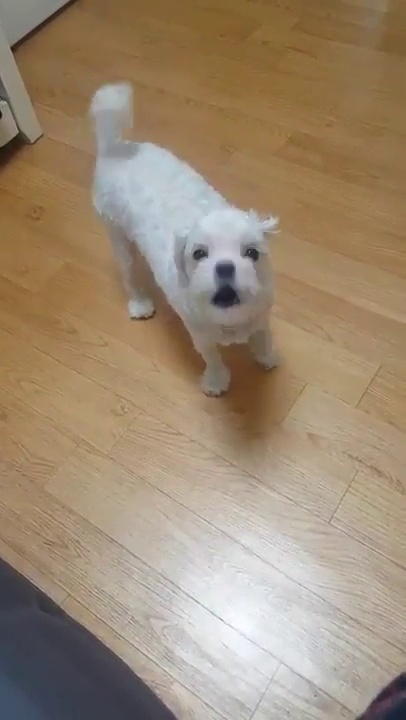

Transcription 완료:  

### 1. 영상 분석 요약:
- 강아지는 흰색 털을 가진 소형견으로 보이며, 자세가 안정적이고 편안한 상태입니다.
- 강아지가 주변을 살피며 약간의 움직임을 보이고 있으며, 관심을 끌기 위해 보호자 쪽으로 다가가는 모습이 관찰됩니다.
- 마지막 프레임에서는 강아지가 입을 벌리고 소리를 내고 있는 모습이 나타나며, 이는 주의나 반응을 요구하는 행동일 수 있습니다.

### 2. 오디오 분석 요약:
- 오디오에서 강아지가 짖는 소리가 들리며, 이는 주의를 끌기 위한 것으로 보입니다.
- 짖음의 톤과 강도는 흥분이나 관심을 나타내는 것으로 해석될 수 있습니다.
- 배경 소음은 없거나 최소화되어 있으며, 강아지의 소리가 잘 들립니다.

### 3. 종합 분석:
- 강아지는 편안한 환경에서 보호자에게 반응하고 있으며, 소리를 내는 것은 관심을 표현하는 행동으로 보입니다.
- 전반적으로 건강하고 활발한 모습으로, 특별한 문제나 스트레스 징후는 나타나지 않습니다.
- 강아지가 보호자와의 상호작용을 원하고 있는 것으로 보이며, 이 시점에서 긍정적인 경험을 제공하는 것이 중요합니다.




In [46]:
import os
import cv2
import base64
import time
from moviepy.editor import VideoFileClip
from PIL import Image, ImageDraw, ImageFont  # PIL에서 필요한 모듈을 가져옵니다.
from IPython.display import display  # Jupyter Notebook에서 display를 가져옵니다.
import io  # BytesIO를 사용하기 위해 io 모듈을 가져옵니다.

# LLM 분석 템플릿
llm_analysis_template = """
    ** 역할 **
    당신은 20년간 강아지에 대해 공부한 수의사 및 행동 분석가입니다.
    강아지에 대한 풍부한 경험과 전문적인 지식을 보유하고 있습니다.
    제공받은 영상과 오디오를 확인하여 강아지에 대한 분석을 진행합니다.

    ** 분석 프로세스 **
    1. 영상 분석: 
       - 제공된 프레임 단위 이미지를 순서대로 분석합니다.
       - 강아지의 자세, 움직임, 표정을 관찰합니다.
       - 주변 환경과 상황적 맥락을 파악합니다.
       - 보호자가 있다면 그들의 행동도 분석합니다.

    2. 오디오 분석: 
       - 오디오 파형과 주파수 분석으로 강아지의 소리(짖음, 울음 등)의 특성을 파악합니다.
       - 배경 소음이나 다른 소리들도 고려합니다.

    3. 종합 분석:
       - 영상과 오디오 정보를 종합하여 강아지의 전반적인 상태를 평가합니다.
       - 행동 패턴, 감정 상태, 건강 상태에 대한 의견을 제시합니다.
       - 특이사항이나 문제점이 있다면 언급합니다.

    ** 분석 결과 형식 **
    분석 결과를 다음 형식으로 제공해 주세요:
    1. 영상 분석 요약: [영상에서 관찰된 주요 사항들을 간결하게 서술]
    2. 오디오 분석 요약: [오디오에서 파악된 주요 정보를 간결하게 서술]
    3. 종합 분석: [영상과 오디오 정보를 종합한 전반적인 분석 결과]

    주어진 정보를 바탕으로 강아지의 상태를 전문가적 관점에서 분석해 주세요.
"""

def analyze_video(file_path, seconds_per_frame=2):
    base64Frames = []
    base_video_file, _ = os.path.splitext(file_path)
    video = cv2.VideoCapture(file_path)
    if not video.isOpened():
        raise Exception("Error opening video file")
    
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)
    
    curr_frame = 0
    while curr_frame < total_frames - 1:
        video.set(cv2.CAP_PROP_POS_FRAMES, curr_frame)
        success, frame = video.read()
        if not success:
            break
        
        _, buffer = cv2.imencode(".jpg", frame)
        base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        curr_frame += frames_to_skip
    
    video.release()

    clip = VideoFileClip(file_path)
    audio_path = f"{base_video_file}.mp3"
    try:
        if clip.audio:
            clip.audio.write_audiofile(audio_path, bitrate="32k")
            clip.audio.close()
        else:
            audio_path = None
    except Exception as e:
        audio_path = None
    clip.close()
    
    return base64Frames, audio_path

def summarize_video(base64Frames, audio_path):
    summary_text = ""
    
    # 비디오 프레임을 표시합니다.
    display_handle = display(None, display_id=True)
    for img in base64Frames:
        # base64로 인코딩된 이미지를 디코딩하여 PIL 이미지로 변환
        image_data = base64.b64decode(img)
        image = Image.open(io.BytesIO(image_data))  # BytesIO를 사용하여 이미지 열기
        display_handle.update(image)
        time.sleep(0.025)

    # 오디오 경로가 None이 아닌 경우에만 transcription을 실행합니다.
    if audio_path is not None:
        with open(audio_path, 'rb') as audio_file:
            transcription = client.audio.transcriptions.create(
                model="whisper-1",
                file=audio_file
            )
            audio_text = transcription.text

            print("Transcription 완료:", audio_text, '\n')
            summary_text += audio_text + "\n"

            response_both = client.chat.completions.create(
                model="gpt-4o-mini-2024-07-18",
                messages=[
                    {"role": "system", "content": llm_analysis_template},
                    {"role": "user", "content": [
                        "이건 비디오 영상의 프레임 이미지.",
                        *map(lambda x: {"type": "image_url",
                                         "image_url": {"url": f"data:image/jpg;base64,{x}", "detail":"low"}}, base64Frames),
                        {"type": "text", "text": f"이건 비디오 영상의 오디오 {audio_text}"}
                    ]},
                ],
                temperature=0.6
            )
            print(response_both.choices[0].message.content)
            summary_text += response_both.choices[0].message.content + "\n"
            print("\n", "="*100, "\n")

    else:
        print("오디오 내용이 없습니다. Transcription은 스킵합니다", '\n')

        # 오디오가 없는 경우에도 비디오 프레임에 대한 분석을 수행합니다.
        response_vis = client.chat.completions.create(
            model="gpt-4o-mini-2024-07-18",
            messages=[
                {"role": "system", "content": llm_analysis_template},
                {"role": "user", "content": [
                    "이건 비디오 영상의 프레임 이미지.",
                    *map(lambda x: {"type": "image_url",
                                     "image_url": {"url": f'data:image/jpg;base64,{x}', "detail": "low"}}, base64Frames)
                ]},
            ],
            temperature=0.6
        )
        print(response_vis.choices[0].message.content)
        summary_text += response_vis.choices[0].message.content + "\n"
        print("\n", "="*100, "\n")

    return summary_text

# 비디오 파일 경로를 지정하여 실행
video_file_path = source 
base64Frames, audio_path = analyze_video(video_file_path)
summary_text = summarize_video(base64Frames, audio_path)

#### STEP.5 Vector Search Query 생성, Rag Context 생성

In [88]:
def generate_query(yolo_text, lstm_text, summary_text):
    # 쿼리 템플릿에 통합된 텍스트를 삽입
    query_template = f"""
    당신은 강아지 행동 분석 전문가입니다. 주어진 정보를 바탕으로 강아지의 상태를 종합적으로 요약해야 합니다.

    ** 입력 정보 **
    1. YOLO 모델 결과: {yolo_text} (강아지 품종 정보)
    2. LSTM 모델 결과: {lstm_text} (강아지 행동, 감정, 통증여부, 질병여부, 비정상 행동 정보)
    3. LLM 비디오/오디오 분석 요약: {summary_text} (강아지의 시각적 행동 패턴, 소리, 환경 정보 등)

    ** 요약 지침 **
    1. 모든 입력 정보를 통합하여 강아지의 상태를 종합적으로 설명하세요.
    2. 품종, 주요행동, 감정상태, 건강상태, 환경적 요인을 포함해주세요.
    3. 영상 속 강아지의 특이사항이나 문제점, 솔루션이 필요하다면 말해주세요.
    4. 전체 요약은 2-3문장으로 제한하세요.
    5. 요약은 키워드 중심으로 작성하고, 불필요한 관사나 조사는 생략하세요.

    위의 지침을 참고하여, 주어진 모든 정보를 바탕으로 강아지의 상태를 종합적으로 요약해주세요.
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": query_template},
            {"role": "user", "content": "비디오를 종합적으로 요약해주세요."}
        ],
        max_tokens=100
    )
    
    query = response.choices[0].message.content
    return query

summary_query = generate_query(yolo_text, lstm_text, summary_text)

# 결과 출력
print("LLM 요약 결과:", summary_query)

LLM 요약 결과: Maltese dog, 활발하며 호기심 많음, 건강 상태 양호, 행동 문제 없음. 환경 적응 잘, 특이사항 없음.


In [92]:
def get_ret():
    # 임베딩 모델 설정
    model_name = "BAAI/bge-m3"
    model_kwargs = {"device": "cpu"}
    encode_kwargs = {"normalize_embeddings": True}
    embeddings_model = HuggingFaceEmbeddings(
        model_name=model_name, 
        model_kwargs=model_kwargs, 
        encode_kwargs=encode_kwargs
    )
    
    # dog 문서
    index_name_json = 'dog_test'
    dbName_json = "dbsparta"
    collectionName_json = "dog"
    collection_json = db_client[dbName_json][collectionName_json]

    vectorStore_json = MongoDBAtlasVectorSearch(
        embedding=embeddings_model,
        collection=collection_json,
        index_name=index_name_json,
        embedding_key="embedding",  # embedding 필드의 이름
        text_key="content"           # content 필드의 이름
    )

    # 여러 검색기 생성
    retriever_json = vectorStore_json.as_retriever()
    
    # MergerRetriever를 사용하여 모든 검색기 통합
    merger_retriever = MergerRetriever(retrievers=[retriever_json])
    
    return merger_retriever

def rag_qa(query, k=3):
    retriever = get_ret()  # 통합된 검색기 가져오기
    try:
        # MergerRetriever는 get_relevant_documents 메소드를 사용합니다
        documents = retriever.get_relevant_documents(query)  # 쿼리를 전달
        
        # 점수를 기준으로 정렬할 수 없으므로, 단순히 상위 k개의 문서를 선택합니다
        search_results = documents[:k]
        
        # 검색 결과의 구조 확인 및 결과를 딕셔너리 형태로 변환
        formatted_results = []
        for doc in search_results:
            # JSON 데이터에서 속성에 접근
            formatted_results.append({
                "content": doc.get("content", ""),  # JSON에서 content 속성 확인
                "metadata": doc.get("metadata", {}),  # JSON에서 metadata 속성 확인
                "animationURL": doc.get("animationURL", '')  # JSON에서 animationURL 속성 확인
            })
            print("Document:", doc)  # Document 객체 출력
            print("Content:", doc.get("content", ""))
            print("Metadata:", doc.get("metadata", {}))

        print("RAG QA Result:", formatted_results)  # 디버깅 로그
        
        return formatted_results
    except Exception as e:
        print(f"검색 중 오류가 발생했습니다: {str(e)}")
        return []

# 쿼리 실행
summary_query = "강아지의 식사 습관에 대해 알려줘."  # 예시 쿼리
search_results = rag_qa(summary_query)

# 결과 출력
print("검색된 문서:")
if not search_results:
    print("검색 결과가 없습니다.")
else:
    for result in search_results:
        print(result)  # 전체 결과 객체를 출력

검색 중 오류가 발생했습니다: 'Document' object has no attribute 'get'
검색된 문서:
검색 결과가 없습니다.


#### STEP.6 LLM 모델 최종 답변 생성

In [ ]:
comprehensive_analysis_template = ChatPromptTemplate.from_messages([
    ("system", """
    당신은 20년 경력의 수의사이자 강아지 행동 분석 전문가입니다. 주어진 모든 정보를 종합하여 강아지의 상태를 분석하고 전문적인 조언을 제공해야 합니다.

    ** 입력 정보 **
    1. YOLO 분석 결과: {yolo_text}
    2. LSTM 분석 결과: {lstm_text}
    3. LLM 비디오 분석 결과: {llm_text}
    4. RAG 문서 정보: {context}

    ** 유저와의 상호작용 **
    모든 대화는 한국어로 진행됩니다.

    ** 분석 및 답변 지침 **
    1. 모든 입력 정보를 종합하여 강아지의 상태, 행동, 감정, 건강 상태를 정확히 파악하세요.
    2. YOLO 결과로부터 강아지의 품종과 외형적 특징을 고려하세요.
    3. LSTM 결과를 바탕으로 강아지의 행동 패턴과 감정 상태, 통증여부, 이상행동 여부를 분석하세요.
    4. LLM 비디오 분석 결과를 통해 전반적인 상황 맥락을 이해하세요.
    5. RAG 문서 정보를 활용하여 관련된 전문 지식을 답변에 통합하세요.
    6. 문제가 있다면 그 원인을 간단히 설명하고, 구체적이고 실행 가능한 해결책을 제시하세요.
    7. 보호자가 즉시 실천할 수 있는 실용적인 조언을 포함하세요.
    8. 필요한 경우 전문가 상담이나 병원 방문을 권유하세요.
    9. 답변은 전문적이면서도 이해하기 쉽게 작성하세요.
    
    ** 답변 구조 **
    1. 종합적 상황 요약 (YOLO, LSTM, LLM 결과 통합)
    2. 원인 분석 (해당되는 경우)
    3. 맞춤형 해결책 또는 권장 행동 (RAG 정보 활용)
    4. 추가 조언 또는 주의사항 (필요한 경우)
    5. 결론 및 격려의 말

    주어진 모든 정보를 종합하여 전문적이고 실용적인 분석과 조언을 제공해주세요.
    """),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{question}")
])

def generate_comprehensive_analysis(yolo_text, lstm_text, llm_text, context):
    response = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18", 
        messages=[
            {"role": "system", "content": comprehensive_analysis_template.format(
                yolo_text=yolo_text,
                lstm_text=lstm_text,
                llm_text=llm_text,
                context=context
            )},
            {"role": "user", "content": "강아지의 상태를 분석하고 조언해주세요."}
        ],
        max_tokens=1000
    )
    return response.choices[0].message.content


analysis_result = generate_comprehensive_analysis(yolo_text, lstm_text, llm_text, context)
print(analysis_result)

# AI 파이프라인 정리

1. **YOLO_v8 모델 분석**: 비디오(강아지 품종, keypoint, bounding box)

2. **LSTM 모델 분석**: 키포인트(강아지 행동패턴, 감정, 통증여부, 비정상 행동 정보)
---------------------------------------------------------------------------
3. **LLM 모델 분석**: 비디오(영상, 오디오 분석 - 요약)

4. **Retriever 생성**: 모델 분석 결과(yolo, lstm, llm 텍스트) - LLM 요약

5. **Vector Search, RAG Context 생성**

6. **LLM 모델 최종 답변 생성**: 
   - 품종
   - 행동패턴
   - 감정
   - 통증여부
   - 비정상 행동 정보
   - LLM 요약
   - RAG 문서 정보
   -------------------------------------------------------------------------

#### 병렬처리

In [ ]:
# 비디오 프레임 추출을 병렬화
def extract_frames_parallel(video_path, seconds_per_frame=2):
    video = cv2.VideoCapture(video_path)
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    frames_to_skip = int(fps * seconds_per_frame)

    def process_frame(frame_num):
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        success, frame = video.read()
        if success:
            _, buffer = cv2.imencode(".jpg", frame)
            return base64.b64encode(buffer).decode("utf-8")
        return None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        frames = list(executor.map(process_frame, range(0, total_frames, frames_to_skip)))

    video.release()
    return [frame for frame in frames if frame is not None]

# YOLO 모델 실행을 병렬화
def run_yolo_parallel(yolo_model, source, conf_thresh):
    results = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {executor.submit(yolo_model.predict, source=frame, conf=conf_thresh): frame for frame in source}
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
    return results

# LSTM 모델 실행을 병렬화 (GPU 사용 가능 시)
def run_lstm_parallel(model, keypoints_tensor, skeleton_tensor):
    with torch.cuda.device(0):
        return model(keypoints_tensor.cuda(), skeleton_tensor.cuda())

# OpenAI API 호출을 비동기로 처리
async def call_openai_api_async(client, model, messages, max_tokens):
    async with aiohttp.ClientSession() as session:
        async with session.post(
            "https://api.openai.com/v1/chat/completions",
            headers={"Authorization": f"Bearer {os.getenv('OPENAI_API_KEY')}"},
            json={
                "model": model,
                "messages": messages,
                "max_tokens": max_tokens
            }
        ) as response:
            return await response.json()

# 메인 실행 함수
async def main(video_path, yolo_model, model, keypoints_tensor, skeleton_tensor, client, conf_thresh):
    # 비디오 프레임 추출
    base64Frames = extract_frames_parallel(video_path)

    # YOLO 모델 실행
    yolo_results = run_yolo_parallel(yolo_model, base64Frames, conf_thresh)

    # LSTM 모델 실행 (GPU 사용 가능 시)
    lstm_output = run_lstm_parallel(model, keypoints_tensor, skeleton_tensor)

    # OpenAI API 호출
    tasks = [
        call_openai_api_async(client, "gpt-4o-mini-2024-07-18", [...], 1000),
        call_openai_api_async(client, "gpt-4o-mini-2024-07-18", [...], 100),
        call_openai_api_async(client, "gpt-4o-mini-2024-07-18", [...], 1000)
    ]
    api_results = await asyncio.gather(*tasks)

    # 결과 처리
    # ...

# 비동기 실행
if __name__ == "__main__":
    video_path = "your_video_path.mp4"  # 비디오 파일 경로
    yolo_model = "your_yolo_model"  # YOLO 모델
    model = "your_lstm_model"  # LSTM 모델
    keypoints_tensor = "your_keypoints_tensor"  # 키포인트 텐서
    skeleton_tensor = "your_skeleton_tensor"  # 스켈레톤 텐서
    client = "your_openai_client"  # OpenAI 클라이언트
    conf_thresh = 0.5  # 신뢰도 임계값

    asyncio.run(main(video_path, yolo_model, model, keypoints_tensor, skeleton_tensor, client, conf_thresh))
